In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations

In [20]:
d= np.loadtxt('prices.txt', dtype=float)
d= d.T
d

array([[38.25, 38.11, 37.9 , ..., 36.58, 36.43, 36.24],
       [69.06, 69.98, 69.56, ..., 50.8 , 51.19, 50.64],
       [62.08, 62.39, 62.82, ..., 44.25, 44.02, 43.43],
       ...,
       [24.02, 24.04, 23.76, ..., 15.81, 15.75, 15.74],
       [76.03, 76.05, 75.66, ..., 80.93, 80.8 , 80.5 ],
       [27.5 , 27.54, 27.55, ..., 31.83, 31.78, 31.59]])

In [21]:
returns = np.diff(np.log(d),axis = 1)

In [22]:
selected_indices = [18, 7, 38]
selected_returns = returns[selected_indices, :]
cor_matrix_3 = np.corrcoef(selected_returns)
cor_matrix_3

array([[1.        , 0.05073346, 0.12795815],
       [0.05073346, 1.        , 0.11477601],
       [0.12795815, 0.11477601, 1.        ]])

In [23]:
np.linalg.det(cor_matrix_3)

0.9693694927164949

In [24]:
cor_matrix = np.corrcoef(returns)

In [25]:
cor_matrix

array([[ 1.00000000e+00,  4.36759450e-02,  2.05027598e-02, ...,
         5.96425928e-02, -3.15266153e-02, -1.75141909e-02],
       [ 4.36759450e-02,  1.00000000e+00, -5.23157236e-02, ...,
         3.60833873e-02, -4.61817165e-02,  2.37724744e-02],
       [ 2.05027598e-02, -5.23157236e-02,  1.00000000e+00, ...,
        -1.50047074e-04,  7.12972797e-02,  6.91012684e-02],
       ...,
       [ 5.96425928e-02,  3.60833873e-02, -1.50047074e-04, ...,
         1.00000000e+00,  4.94240221e-02, -2.79210076e-02],
       [-3.15266153e-02, -4.61817165e-02,  7.12972797e-02, ...,
         4.94240221e-02,  1.00000000e+00, -4.32052031e-02],
       [-1.75141909e-02,  2.37724744e-02,  6.91012684e-02, ...,
        -2.79210076e-02, -4.32052031e-02,  1.00000000e+00]])

In [26]:
def find_top_10_asset_triplets(cor_matrix, top_n=10):
    n = cor_matrix.shape[0]
    triplet_scores = []

    # Iterate over all possible 3-asset combinations
    for triplet in combinations(range(n), 3):
        sub_corr = cor_matrix[np.ix_(triplet, triplet)]
        off_diag_sum = np.sum(np.abs(sub_corr)) - np.sum(np.abs(np.diag(sub_corr)))
        triplet_scores.append((triplet, off_diag_sum))

    # Sort triplets by descending off-diagonal sum
    triplet_scores.sort(key=lambda x: x[1], reverse=True)

    # Return top_n triplets and their scores
    return triplet_scores[:top_n]


top_trips=find_top_10_asset_triplets(cor_matrix)
top_trips

[((18, 38, 44), 0.6094624729796041),
 ((7, 18, 38), 0.5869352278805473),
 ((13, 18, 38), 0.5839258123328905),
 ((7, 13, 38), 0.5739484090128633),
 ((7, 38, 39), 0.5575435130958981),
 ((8, 23, 36), 0.5555394943210841),
 ((18, 38, 39), 0.5505376180534016),
 ((7, 23, 38), 0.5273423240913857),
 ((7, 9, 49), 0.5254957916933014),
 ((21, 44, 47), 0.5232308264729979)]

In [27]:
def compute_spread_zscore_3assets(p1, p2, p3):
    # Regress p1 on p2 and p3: p1 = beta1 * p2 + beta2 * p3 + error
    X = np.vstack([p2, p3]).T  # shape (n_samples, 2)
    y = p1
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    spread = y - X.dot(beta)
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

def simulate_trades_3assets(z, entry=1.0, exit=0.0):
    positions = np.zeros(len(z))
    for t in range(1, len(z)):
        if z[t-1] < -entry:
            positions[t] = 1  # Long spread
        elif z[t-1] > entry:
            positions[t] = -1  # Short spread
        elif abs(z[t-1]) < exit:
            positions[t] = 0  # Exit position
        else:
            positions[t] = positions[t-1]  # Hold previous position
    return positions

def compute_pnl_3assets(positions, spread):
    spread_diff = np.diff(spread)
    pnl = positions[:-1] * spread_diff  # lag position by 1
    return np.cumsum(pnl)

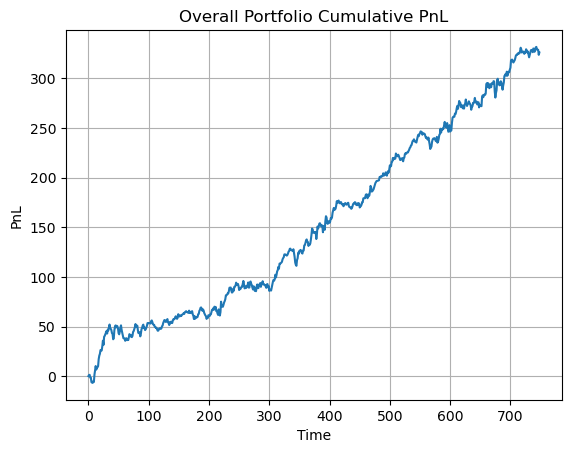

In [28]:
overall_pnl_3 = None
for a in range(9):  # Or len(top_pairs)
    i, j,k = top_trips[a][0]
    p1 = d[i,:]
    p2 = d[j,:]
    p3 = d[k,:]
    



    spread_3, z_3, beta_3 = compute_spread_zscore_3assets(p1, p2, p3)
    positions_3 = simulate_trades_3assets(z_3, entry=1.0, exit=0.0)
    pnl_3 = compute_pnl_3assets(positions_3, spread_3)

    # Pad pnl to the same length if needed
    pnl_3 = np.pad(pnl_3, (0, d.shape[1] - 1 - len(pnl_3)), constant_values=0)

    if overall_pnl_3 is None:
        overall_pnl_3 = pnl_3
    else:
        overall_pnl_3 += pnl_3  # aggregate all pnls into one

# Plot the overall portfolio PnL
plt.plot(overall_pnl_3)
plt.title("Overall Portfolio Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

In [29]:
def analyze_pnl(pnl):
    returns = np.diff(pnl)
    avg_daily_return = np.mean(returns)
    volatility = np.std(returns)
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252)  # assume 252 trading days
    max_drawdown = np.max(np.maximum.accumulate(pnl) - pnl)

    print(f"Total PnL: {pnl[-1]:.2f}")
    print(f"Average Daily Return: {avg_daily_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    print(f"Final score: {avg_daily_return-0.1*volatility}")

analyze_pnl(overall_pnl_3)

Total PnL: 326.19
Average Daily Return: 0.4361
Volatility: 2.5711
Sharpe Ratio: 2.69
Max Drawdown: 17.70
Final score: 0.17897638960738677


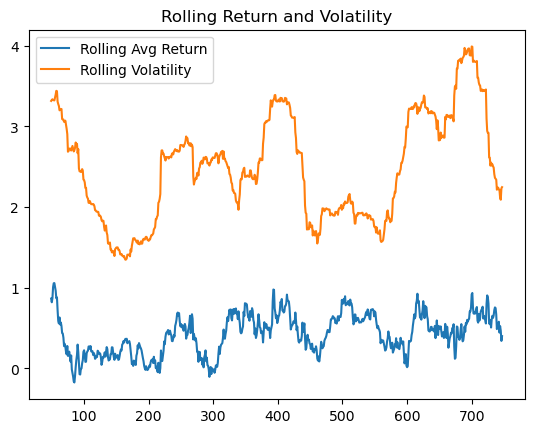

In [31]:
rolling_window = 50
rolling_returns = pd.Series(np.diff(overall_pnl_3)).rolling(rolling_window)

plt.plot(rolling_returns.mean(), label="Rolling Avg Return")
plt.plot(rolling_returns.std(), label="Rolling Volatility")
plt.legend()
plt.title("Rolling Return and Volatility")
plt.show()
